# Experimenting/exploring Neural Networks with PyTorch

In this notebook we experiment with Neural Networks using PyTorch. We start building a simple SoftMax NN to help in developing main algorithm that could be later used for any other architecture with small changes

# Mounting google drive

In order to make it easy to read data from Google Drive, it can be mounted as a "local" unity. This encapsulates the connection to Google API and reduce the amount of coding that would be needed when interacting with Google API

In [1]:
# First check if running on Google Colab
try:
    from google.colab import drive

    # Install required packages
    ! pip install pandarallel
    ! pip install opencv-python

    # Mount Drive
    drive.mount("/content/gdrive", force_remount=True)

    IN_COLAB = True
    file_placement = "/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data"
except:
    IN_COLAB = False

    # Install required packages
    ! pip install opencv-python

    import os
    file_placement = os.path.join(os.getcwd(), "..", "data")
print("running in colab?", IN_COLAB, "\ndata files:", file_placement)

Mounted at /content/gdrive
running in colab? True 
data files: /content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data


In [2]:
import os
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch import nn
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

if IN_COLAB:
    base_folder = os.path.join(file_placement, "..", "..", "Publishing")
else:
    base_folder = os.path.join(file_placement, "..")
data_folder = os.path.join(base_folder, "transformed_images")
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.ToTensor()]
)

dataset = datasets.ImageFolder(data_folder, transform=transform)

We load the dataset into a tensor and then augment it

In [3]:
transform =  transforms.Compose([
    transforms.Resize(255),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()])
dataset_augmented = datasets.ImageFolder(data_folder, transform=transform)

In [4]:
# final_dataset = torch.utils.data.ConcatDataset([dataset, dataset_augmented])
final_dataset = torch.utils.data.ConcatDataset([dataset, dataset_augmented])
generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = torch.utils.data.random_split(final_dataset, [0.75, 0.25])

In [5]:
print(
    "Train dataset size:", len(train_dataset),
    "\nTest dataset size:", len(test_dataset),
    "\nTotal of images:", (len(train_dataset) + len(test_dataset))
)

Train dataset size: 9720 
Test dataset size: 3240 
Total of images: 12960


Batches of size 64, 128 and 256 were attempted, with 128 observations per batch being the one with the best trade-off between use of resources and time to train

In [6]:
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# image, label = next(iter(train_dataloader))

In [7]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Build Neural Network

To experiment with NN we build a simple SoftMax regression with only two layers:

* A layer to flat the 3D Tensor (width X height X channels)
* SoftMax activation layer, with two output channels (one for each class of label)

In [8]:
class SoftMaxRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # define layers
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(195075, 2)

    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        y = self.flatten(x)
        y = self.linear(y)
        return y

Here we check if GPU is available, instantiate our model, pick our loss functions and define our optimizer. We are using one example from Deep Learning class without worrying about "the best choice", as this is just an experiment.

**Note**: in Google Colab, do not forget to change the runtime environment to one with GPU

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# let's instantiate a model
model = SoftMaxRegression().to(device)

# define loss function
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.NLLLoss()

# define optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters())

cuda


Here we initiallize the weights for our model

In [10]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

model.apply(init_weights);

And here we check how our model is working for one batch of our training set

In [11]:
for x_batch, y_batch in train_dataloader:

  print(x_batch.shape)
  print(y_batch.shape)
  print("Features:\n\t", x_batch[:1], "\nLabels:\n\t", y_batch[:1])

  print(nn.Flatten(x_batch))

  x_batch = x_batch.to(device)
  y_batch = y_batch.to(device)

  y_hat = model(x_batch)
  print(y_hat[1])

  ll = loss_fn(y_hat, y_batch )
#   print(ll)

  break   # break after first pair, we just want to observe

torch.Size([128, 3, 255, 255])
torch.Size([128])
Features:
	 tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]) 
Labels:
	 tensor([1])
Flatten(
  start_dim=tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
 

And here we built our train step (epoch) and test it

In [12]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(yhat, y)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()

    # Returns the function that will be called inside the train loop
    return train_step

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []
n_epochs = 10

Finally we train our model for 10 epochs (iterations)

In [13]:
import numpy as np
import time

model.apply(init_weights)   #always good to initialize in the beginning
n_epochs = 10
losses = []
test_losses = []
train_step = make_train_step(model, loss_fn, optimizer)
log_training = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running on:", device)

for epoch in range(n_epochs):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    log_row = {
        "epoch": epoch + 1,
        "start time": time.time(),
        "start GPU time": start}
    print(epoch + 1, "/", n_epochs)
    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)

    print("Train loss:", np.mean(losses))
    log_row["train loss"] = np.mean(losses)
    # torch no_grad makes sure that the nested-below computations happen without gradients,
    # since these are not needed for evaluation
    with torch.no_grad():
        for x_test, y_test in test_dataloader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)

            model.eval()

            yhat = model(x_test)
            test_loss = loss_fn(yhat, y_test)
            test_losses.append(test_loss.item())

        print("Test loss:", np.mean(test_losses))
        log_row["test loss"] = np.mean(test_losses)
    log_row["end time"] = time.time()
    log_row["end GPU time"] = end.record()
    torch.cuda.synchronize()
    log_training.append(log_row)
#print(model.state_dict())

Running on: cuda
1 / 10
Train loss: 6.944773907661438
Test loss: 0.9362641394138336
2 / 10
Train loss: 4.376407756209374
Test loss: 1.2365677553415297
3 / 10
Train loss: 3.1700841874546475
Test loss: 1.1556891624132792
4 / 10
Train loss: 2.6531642097234727
Test loss: 1.160591534972191
5 / 10
Train loss: 2.2289285336732862
Test loss: 1.009375798344612
6 / 10
Train loss: 2.05063098102808
Test loss: 0.9706639890869458
7 / 10
Train loss: 1.8574275015578383
Test loss: 0.8930364787578583
8 / 10
Train loss: 1.7344163286996384
Test loss: 1.2801281167566776
9 / 10
Train loss: 1.661100941537707
Test loss: 1.190560290912787
10 / 10
Train loss: 1.5624438572873671
Test loss: 1.2107244869172573


In [14]:
training_statistics = pd.DataFrame(log_training)

<function matplotlib.pyplot.show(close=None, block=None)>

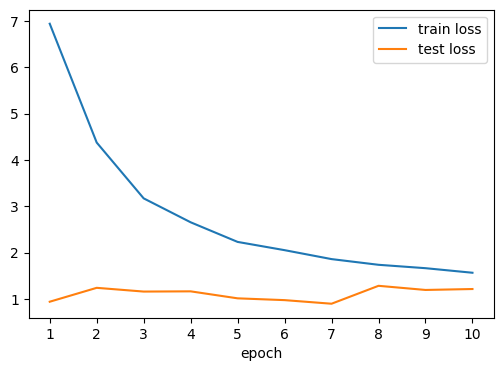

In [26]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(training_statistics["train loss"], label="train loss")
plt.plot(training_statistics["test loss"], label="test loss")
plt.legend()
plt.xlabel("epoch")
plt.xticks(training_statistics.index, training_statistics["epoch"])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

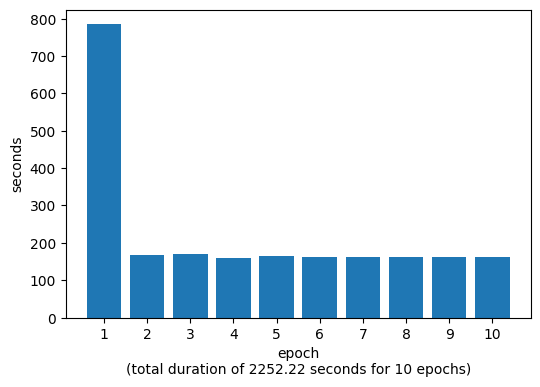

In [33]:
training_statistics["duration"] = training_statistics["end time"] - training_statistics["start time"]
plt.rcParams["figure.figsize"] = (6, 4)
plt.bar(training_statistics["epoch"], training_statistics["duration"])
plt.ylabel("seconds")
total_duration = training_statistics["duration"].sum()
plt.xlabel(f"epoch\n(total duration of {str(round(total_duration, 2))} seconds for 10 epochs)")
plt.xticks(training_statistics["epoch"])
plt.show
# training_statistics

Let's check the accuracy of trained model

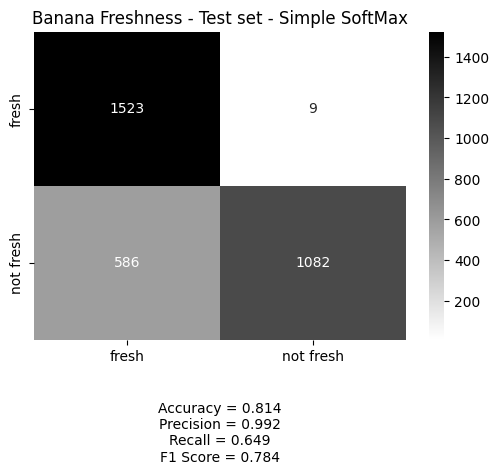

In [27]:
def check_performance(model, test_dataloader, type_of_set):
  all_true = []
  all_preds = []
  model.eval()
  for X, y in test_dataloader:
    X = X.to(device)
    y = y.to(device)

    trues = y
    preds = model(X).argmax(axis=1)
    all_true.extend(list(trues.cpu().numpy()))
    all_preds.extend(list(preds.cpu().numpy()))

  performance = pd.DataFrame({"true": all_true, "predicted": all_preds})
  cm = confusion_matrix(performance["true"], performance["predicted"])
  sns.heatmap(cm, annot=True, fmt=".0f", cmap="binary",
              xticklabels = ["fresh", "not fresh"], yticklabels = ["fresh", "not fresh"])
  #Metrics for Binary Confusion Matrices
  accuracy  = np.trace(cm) / float(np.sum(cm))
  precision = cm[1,1] / sum(cm[:,1])
  recall    = cm[1,1] / sum(cm[1,:])
  f1_score  = 2*precision*recall / (precision + recall)
  stats_text = "\n\nAccuracy = {:0.3f}\nPrecision = {:0.3f}\nRecall = {:0.3f}\nF1 Score = {:0.3f}".format(
      accuracy, precision, recall, f1_score)

  plt.title(f"Banana Freshness - {type_of_set}")
  plt.xlabel(stats_text)
  # return performance

check_performance(model, test_dataloader, "Test set - Simple SoftMax")
# test_dataloader

Even without worrying about "the right choice" or performance, our test model was able to achieve an accuracy of 0.8416 (84.16%). It is important to notice that our test loss was always below the train loss, which indicates a good generalization of the model.